<a href="https://colab.research.google.com/github/9berny9/cookie_cats_analysis/blob/main/cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NAČTENÍ KNIHOVEN

In [393]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import chi2_contingency

# READING DATA

In [394]:
url = 'https://raw.githubusercontent.com/9berny9/cookie_cats_analysis/main/cookie_cats.csv?token=GHSAT0AAAAAABTXMXCXNO4434XQSJR7QTR2YWG4M2Q'
df = pd.read_csv(url, encoding='unicode_escape')

In [395]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


Data neobsahují nulové hodnoty.

In [396]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [397]:
df.tail()

,userid,version,sum_gamerounds,retention_1,retention_7
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False
90188,9999861,gate_40,16,False,False


# Základní popisné statistiky

In [398]:
df.sum_gamerounds.describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

- data neobsahují nulové hodnoty (počet záznamů je shodný s počtem uživatelů)
- 25% uživatelů z našeho datasetu odehrálo 5 her během 14 dnů.
- 50% medián uživatelů z našeho datasetu odehrálo 16 her během 14 dnů.
- 75% uživatelů z našeho datasetu odehrálo 51 her během 14 dnů.
- minimální počet odehraných her je 0, takže uživatel pouze nainstaloval hru
- maximální počet odehraných her je 49854 a tento počet her se výrazně vychyluje od ostatních odehraných her
- směrodatná odchylka se výrazně liší od průměru, takže se v měření nachází odlehlá měření

# Kontrola a čištění dat

In [399]:
df.isnull().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

V datech se nenachází Null hodnoty

In [400]:
# check unique user id
df.userid.nunique()

90189

User ID je vždy unikátní.

In [401]:
df.version.nunique()

2

In [402]:
df.version.value_counts()

gate_40    45489
gate_30    44700
Name: version, dtype: int64

V datasetu se nachází pouze dvě verze módů, což odpovídá A/B testování a Gate 40 má více záznamů než Gate 30.


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


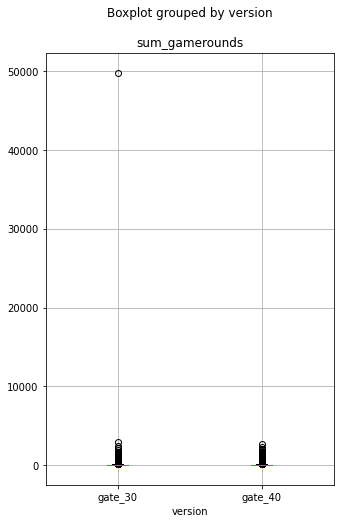

In [403]:
df.boxplot(column="sum_gamerounds", by="version", figsize=(5, 8));

Z krabicového grafu jsme nalezli výskyt odlehlých měření, které je potřeba vyfiltrovat.

In [404]:
# rozdělení dat podle A/B testu
data_gate30 = df[df.version == "gate_30"].sum_gamerounds
data_gate40 = df[df.version == "gate_40"].sum_gamerounds

In [405]:
# Metoda IQR - interquartal range 
# Gate 30
Q1_a = data_gate30.quantile(0.25)
Q3_a = data_gate30.quantile(0.75)
IQR_a = Q3_a - Q1_a
dolni_hranice_a = Q1_a - 1.5 * IQR_a
horni_hranice_a = Q3_a + 1.5 * IQR_a

# Gate 40
Q1_b = data_gate40.quantile(0.25)
Q3_b = data_gate40.quantile(0.75)
IQR_b = Q3_b - Q1_b
dolni_hranice_b = Q1_b - 1.5 * IQR_b
horni_hranice_b = Q3_b + 1.5 * IQR_b

# Zobrazení
print("Dolní hranice pro Gate 30: ", dolni_hranice_a)
print("Horní hranice pro Gate 30: ", horni_hranice_a)
print('')
print("Dolní hranice pro Gate 40: ", dolni_hranice_b)
print("Horní hranice pro Gate 40: ", horni_hranice_b)

Dolní hranice pro Gate 30:  -62.5
Horní hranice pro Gate 30:  117.5

Dolní hranice pro Gate 40:  -65.5
Horní hranice pro Gate 40:  122.5


In [406]:
# kopie datasetu pro analýzu
df1 = df.copy()

In [407]:
# odstranění záznamů nad horní hranicí rozsahu
df1.drop(df1[(df1["version"] == "gate_30") & (df1['sum_gamerounds'] > horni_hranice_a)].index, inplace=True)
df1.drop(df1[(df1["version"] == "gate_40") & (df1['sum_gamerounds'] > horni_hranice_b)].index, inplace=True)

Pro přesnější výsledek hypotézy jsem vyfiltroval pro každou bránu hodnoty vypočítané z interkvartálního rozsahu a pouze hodnoty větší než je horní hranice.

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


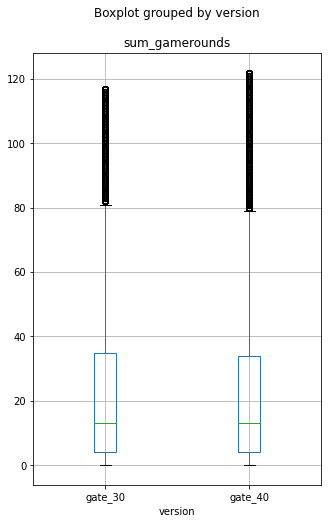

In [408]:
df1.boxplot(column="sum_gamerounds", by="version", figsize=(5, 8));

In [409]:
df1.version.value_counts()

gate_40    40471
gate_30    39493
Name: version, dtype: int64

Vyfiltrovaný dataset nyní obsahuje **79 964** měření.  
pro gate_30: **39 493 záznamů**  
pro gate_40: **40 471 záznamů**  

Dataset je vyfiltrovaný a považuji ho za připravený k vytvoření hypotézy A/B testování.

# Průzkum dat

V této částu si statisticky vyhodnotím a zodpovím základní otázky, které mi umožní porozumět chování hráčů. Pro přehlednost si dataframe rozdělím na dva dataframy podle skupin verzí.

In [410]:
# proměnné dataframu rozdělený podle skupin
df_30 = df1[df1["version"] == "gate_30"]
df_40 = df1[df1["version"] == "gate_40"]

## Počet hráčů, kteří hru pouze nainstalovali, ale nikdy ji nehráli

In [411]:
inactive_users = df1[df1["sum_gamerounds"] == 0].userid.count()

In [412]:
inactive_percent = round((inactive_users / df.userid.count()) * 100, 2)

In [413]:
print(f"Počet hráčů. kteří nikdy hru nehráli je: {inactive_users}, což je {inactive_percent}% ze všech hráčů")

Počet hráčů. kteří nikdy hru nehráli je: 3994, což je 4.43% ze všech hráčů


## Kolik průměrně procent hráčů se vrátilo po 1 dni a 7 dnech?

### Retention 1

In [414]:
df_30.retention_1.value_counts(normalize=True)

False    0.612564
True     0.387436
Name: retention_1, dtype: float64

In [415]:
df_40.retention_1.value_counts(normalize=True)

False    0.615577
True     0.384423
Name: retention_1, dtype: float64

**Gate 30**:  Pouze 38,74% hráčů se vrací do hry po 1 dni.  
**Gate 40**: Pouze 38,44% hráčů se vrací do hry po 1 dni.  

v obou skupinách odchází ze hry nad 60% hráčů po 1 dni, což je velmi výrazné a nežádoucí. Je potřeba se zkusit s vývojáři a marketingovým oddělením zamyslet nad tím, jakým způsobem hráče zaujmout při prvním spuštění hry a na těchto změnách zkusit provést další A/B testování.

### Retention 7

In [416]:
df_30.retention_7.value_counts(normalize=True)

False    0.883473
True     0.116527
Name: retention_7, dtype: float64

In [417]:
df_40.retention_7.value_counts(normalize=True)

False    0.889155
True     0.110845
Name: retention_7, dtype: float64

**Gate 30**:  Pouze 11,65% hráčů se vrací do hry po 7 dnech.  
**Gate 40**: Pouze 11,08% hráčů se vrací do hry po 7 dnech.  

Z průměru počtu hráčů podle skupin, kteří se vrací do hry lze vidět minimální rozdíl přibližně kolem **0,5% poklesu pro Gate_40** v obou retenčních případech.  

Tato změna je malá, ale dává nám první informaci o poklesu počtu hráčů při nastavení Gate 40. Tato malá změna může být mnohem výraznější při větším množství sesbíraných dat. Proto je potřeba zvolit vhodnou metodu, kterou budu moct ověřit jestli opravdu při Gate 40 v budoucnu bude docházet pravidelně k poklesu. Pro testování hypotéz budu používat metodu **Bootstraping**.

## Jak se hráči chovají s přibývajícím počtem her?

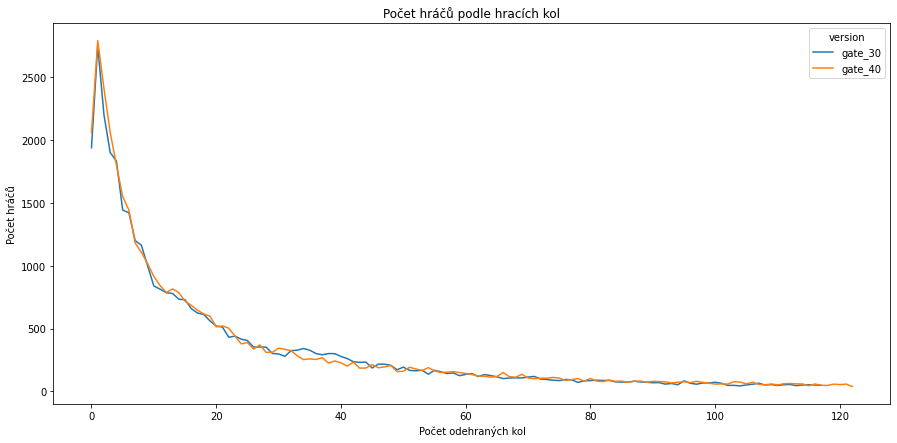

In [418]:
fig, ax = plt.subplots(figsize=(15,7))
ax = df1.groupby(['sum_gamerounds', "version"]).count()['userid'].unstack().plot(ax=ax)
ax.set_xlabel("Počet odehraných kol")
ax.set_ylabel("Počet hráčů")
ax.set_title("Počet hráčů podle hracích kol")
plt.show();

Z grafu lze vidět, že většina hráčů odehraje pouze prvních pár kol. Zde je vidět, že naprostá většina hráčů neodehraje ani 20 kol hry. Zde je potřeba zjistit jestli odcházení hráčů není způsobeno dosažením platební brány nebo obtížností hry a vyvodit závěry jak udržet hráče déle ve hře. Chování obou testovaných skupin je velice podobné.

Ze zajímavosti si zobrazíme ještě distribuci podle rozsahu odehraných kol pro obě skupiny. Budeme sledovat, v kterém rozmezí kol se nachází výrazné změny.

In [419]:
bins = [0,1,10,20,30,40,50,60,70,80,90,100,200]
plot_30 = df_30.groupby(pd.cut(df_30["sum_gamerounds"], bins=bins)).userid.count()
plot_40 = df_40.groupby(pd.cut(df_40["sum_gamerounds"], bins=bins)).userid.count()

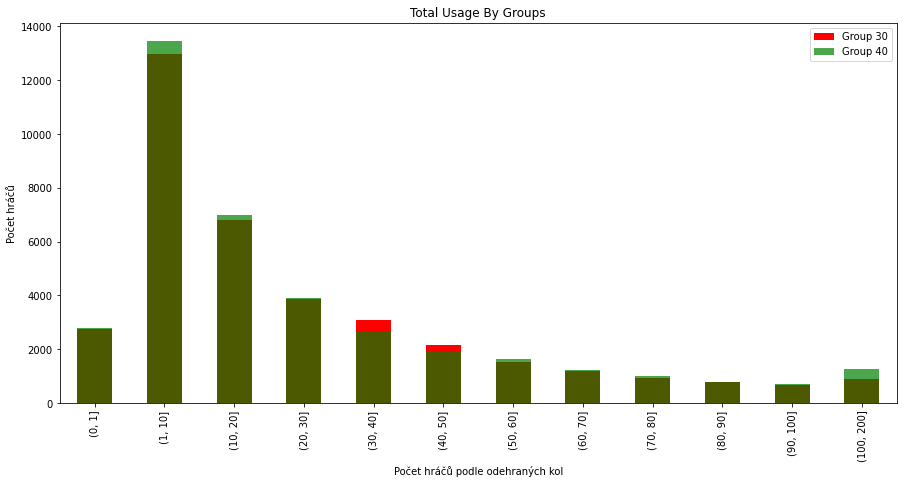

In [420]:
# Plotting the distribution of players that played 0 to 100 game rounds
fig, ax = plt.subplots(figsize=(15,7))
ax = plot_30.plot(kind = 'bar', y="userid", color = "red", alpha = 1, 
                       title = 'Total Usage By Groups')
plot_40.plot(kind = 'bar', y="userid", ax=ax, color = "green", alpha = 0.7 )
ax.set_xlabel("Počet hráčů podle odehraných kol")
ax.set_ylabel("Počet hráčů")
plt.legend(["Group 30", "Group 40"]);

Rozdíly mezi skupinami jsou minimální a největší změny nastávají behem **1 až 10** kola a také **30 až 40 kola**. Kolem 30 až 40 kola by mohly změny nastávat otevřením platební brány.

## Jaký je průměrný počet odehraných kol hry každé skupiny?

Zde mě budou zajímat pouze aktivní hráči a z toho důvodu vyfiltruji hráče, kteří neodehráli žádné kolo.

In [421]:
df_30[df_30.sum_gamerounds > 0].sum_gamerounds.describe()

count    37556.000000
mean        24.813558
std         26.701846
min          1.000000
25%          5.000000
50%         14.000000
75%         36.000000
max        117.000000
Name: sum_gamerounds, dtype: float64

In [422]:
df_40[df_40.sum_gamerounds > 0].sum_gamerounds.describe()

count    38414.000000
mean        25.544307
std         28.338013
min          1.000000
25%          5.000000
50%         14.000000
75%         36.000000
max        122.000000
Name: sum_gamerounds, dtype: float64

Průměrný počet odehraných kol se příliš neliší a hráči obou skupin průměrně odehrají **25 kol**.

 # Testování Hypotéz

 ## Test chí-kvadrát
 Pro tento test si určíme dvě hypotézy:  
 - **Nulová hypotéza**: retence je stejná pro obě skupiny
 - **Alternativní hypotéza**: hráči ze skupiny Gate 30 mají vyšší udržení ve hře

In [423]:
contigency_retention_1 = pd.crosstab(df1['version'], df1['retention_1'], normalize="index") 

In [424]:
contigency_retention_7 = pd.crosstab(df1['version'], df1['retention_7'], normalize="index") 

In [425]:
contigency_retention_1

retention_1,False,True
version,,
gate_30,0.612564,0.387436
gate_40,0.615577,0.384423


In [426]:
contigency_retention_7

retention_7,False,True
version,,
gate_30,0.883473,0.116527
gate_40,0.889155,0.110845


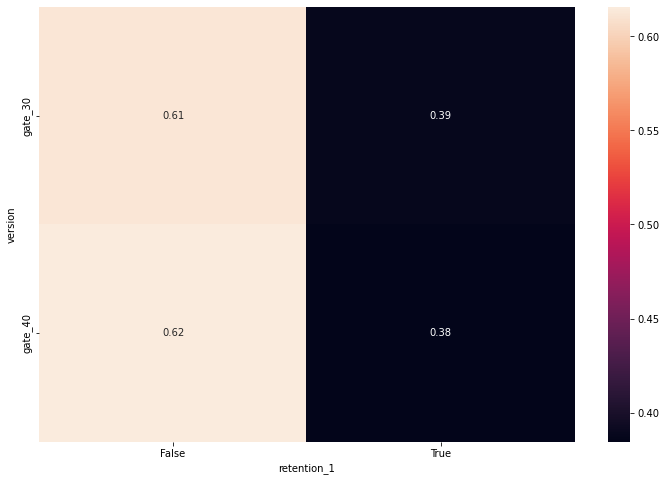

In [427]:
plt.figure(figsize=(12,8)) 
sns.heatmap(contigency_retention_1, annot=True);

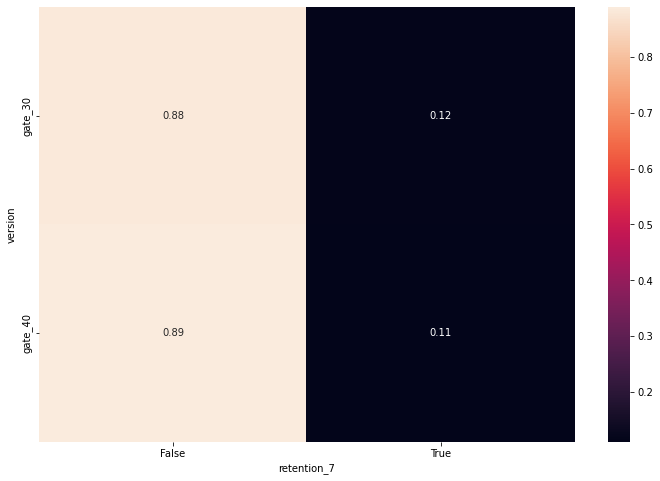

In [428]:
plt.figure(figsize=(12,8)) 
sns.heatmap(contigency_retention_7, annot=True);

In [429]:
alpha = 0.05

In [430]:
# Chi-square test
c1, p1, _, _ = chi2_contingency(contigency_retention_1) 
print(f'Test statistic: {c1}\np-value: {round(p1 * 100,2)}%')

Test statistic: 2.0971202340490707
p-value: 14.76%


In [431]:
# Chi-square test
c2, p2, _, _ = chi2_contingency(contigency_retention_7) 
print(f'Test statistic: {c2}\np-value: {round(p2 * 100,2)}%')

Test statistic: 4.905985046255749
p-value: 2.68%


In [432]:
if p1 < alpha:
    print("Pro retention_1 odmítáme nulovou hypotézu")
else:
    print("Pro retention_1 příjímáme nulovou hypotézu")

Pro retention_1 příjímáme nulovou hypotézu


In [433]:
if p2 < alpha:
    print("Pro retention_7 odmítáme nulovou hypotézu")
else:
    print("Pro retention_7 příjímáme nulovou hypotézu")

Pro retention_7 odmítáme nulovou hypotézu


### **Výsledek hypotéz:**

**Retention 1**:  
Podle našeho chí-kvadrát testu nebyl po **1 dni** mezi oběma verzemi výrazný rozdíl, který nebyl větší než 5% hladiny významnosti, takže předpokládáme že mezi skupinami není signifikantní rozdíl po 1 dni hraní.

**Retention 7**:  
U 7 denní retence se potvrzuje hypotéza, že mezi skupinami je signifikantní rozdíl větší než 5% hladiny významnosti a potvrzuje hypotézu, že Gate 30 má po 7 dnech vyšší udržitelnost hráčů ve hře.

## Bootstraping